In [1]:
from scwfae.data.ptbxlDS import PtbxlAllChanDS
from scwfae.model.ConvolutionalEcgModules import ConvolutionalEcgVAE
import torch
from torch.utils.data import random_split, DataLoader

torch.manual_seed(42)

-- SCWFAE --


In [2]:
ds = PtbxlAllChanDS(lowres=True)
_, val_ds = random_split(ds, lengths=[0.9, 0.1])
val_dl = DataLoader(val_ds, batch_size=len(val_ds))

sig, labels = next(iter(val_dl))
sig.shape

torch.Size([1886, 12, 1000])

In [3]:
m = ConvolutionalEcgVAE(n_filters=8, latent_dim=64)
m.load_state_dict(torch.load('cache/archivedmodels/ecgvae_f8l64.pt', weights_only=True))

m

ConvolutionalEcgVAE(
  (encoder): ConvolutionalEcgEncoder(
    (conv1): Conv1d(1, 8, kernel_size=(7,), stride=(1,), padding=(3,))
    (conv2): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (decoder): ConvolutionalEcgDecoder(
    (conv1): ConvTranspose1d(64, 8, kernel_size=(3,), stride=(1,))
    (conv2): ConvTranspose1d(8, 1, kernel_size=(7,), stride=(1,))
  )
  (fc_mean): Linear(in_features=64, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=64, bias=True)
  (fc_decode): Linear(in_features=64, out_features=64, bias=True)
)

In [10]:
n, channels, sig_len = sig.shape

encodings = m.encode(sig.view(n* channels, sig_len).unsqueeze(1))
encodings = encodings.view(n, channels * 64)
encodings.shape


torch.Size([1886, 768])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

for label_name, y in labels.items():
    clf = RandomForestClassifier(n_jobs=-1)
    scores = cross_val_score(clf, encodings.detach().numpy(), y.detach().numpy(), cv=5, scoring='roc_auc')
    print(f"{label_name}: {scores.mean()})

0.49714308191725454
0.48501315805685474
0.4486826241134752
0.49296969696969706
0.5915175104266
0.5171828225753644


torch.Size([12, 1000])
torch.Size([12, 1, 1000])


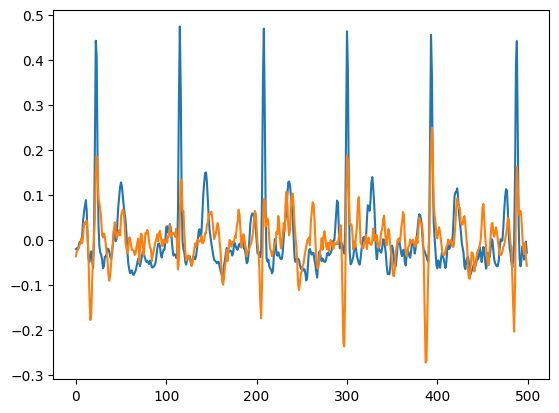

In [14]:
reproduction, mu, sigma = m(sig.unsqueeze(1))
reproduction.shape

import matplotlib.pyplot as plt

print(sig.shape)
print(reproduction.shape)

plt.plot(
    range(500),
    sig[0, 0:500],
    label="original",
)
plt.plot(
    range(500),
    reproduction[0, :, 0:500].squeeze().detach().cpu().numpy(),
    label="reconstruction",
)